In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from keras.models import Sequential
from keras.layers import Conv1D, Dense, Flatten, MaxPooling1D, Reshape # Реализация сверточного слоя\ ... \ выпрямляющий вектор\ выходной слой
from keras.wrappers.scikit_learn import KerasClassifier
from keras import optimizers, regularizers, losses
import tensorflow as tf

Using TensorFlow backend.


# Help Functions

In [2]:
def to_numpy_array_reshape(classes_count, y, classes_start):
    n_y = []
    step = classes_start
    for i in y:
        i = [0 if k != (i-step) else 1 for k in range(int(classes_count))]
        n_y.append(i)
        #print(i)
    return np.array(n_y).astype('float64')

In [3]:
def plot_nn_result(start, story):
    val_loss = story.history['val_loss'][start:]
    val_accuracy = story.history['val_accuracy'][start:]
    accuracy = story.history['accuracy'][start:]
    loss = story.history['loss'][start:]
    x = range(len(story.history['val_accuracy']))[start:]

    fig, ax = plt.subplots(figsize=(15,8))
    ax.plot(x, val_accuracy, label='val_accuracy')
    ax.plot(x, accuracy, label='accuracy')
    ax.plot(x, val_loss, label='val_loss')
    ax.plot(x, loss, label='loss')
    plt.title('model loss/accuracy/val_accuracy')
    plt.legend()
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()

In [4]:
def CNNVS_G(
    classes_count,
    input_shape,
    filters = 2,
    kernel_size = 5,
    strides = 2,
    lambda1 = 10**-5,
    lambda2 = 10**-2,
    learning_rate = 0.00000001,
    momentum = 0.7,
    beta_1 = 0.9,
    beta_2 = 0.999,
    #max_pool = 2,
    SDL = 512
    ):  
    model = Sequential([
                      Reshape((input_shape, 1), input_shape=(input_shape,)),
                      Conv1D(filters, kernel_size=kernel_size, strides=strides,
                             padding='valid', activation='relu',
                             kernel_regularizer = regularizers.l1_l2(l1=lambda1, l2=lambda2),
                             input_shape = (input_shape,1)),
                      #MaxPooling1D(2),
                      Flatten(),
                      Dense(SDL,activation='relu'),
                      Dense(classes_count,activation='softmax')
  ])
    # Варианты оптимизаторов
    sgd = optimizers.SGD(lr=learning_rate, decay=1e-6, momentum=momentum, nesterov=True)
    adam = optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, amsgrad=False)
    
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Data

In [5]:
fuel_data = pd.read_csv('all_spectras.csv')
fuel_data = fuel_data.drop('Unnamed: 0', axis=1)
fuel_data

,"300,857","303,05","305,242","307,433","309,623","311,812",314,"316,187","318,373","320,558",...,"2003,295","2004,468","2005,64","2006,811","2007,98","2009,149","2010,317","2011,484","2012,65",label
0,"736,5","734,3","761,4","752,8","738,4","721,3","716,8","696,1","681,4","690,3",...,"-53,6",-49,"-57,1","-51,5","-54,1","-49,2","-61,8","-48,5","-51,3",benz92
1,"9252,3","9326,9",9335,9327,"9243,4","9181,5",9047,"8947,1","8869,8","8800,7",...,"1427,8","1425,6","1409,3","1405,9","1397,7",1388,"1364,8","1359,7","1348,7",benz92
2,"1668,1","1690,1","1693,4","1691,8","1667,4","1657,9","1623,8","1599,5","1596,6","1571,7",...,"110,6","124,4","106,7","112,9","110,1","105,8","97,8","109,9","104,7",benz92
3,"2627,5","2639,7",2662,"2657,4","2629,2","2610,3",2556,"2551,7","2506,6","2482,7",...,"266,6","273,8","259,7","269,7","259,3","267,4","252,4","266,3","262,1",benz92
4,"3546,9","3580,5","3584,6",3583,"3549,2","3513,3","3433,4","3395,3","3375,6","3343,3",...,"442,2","440,2","428,3","420,1","425,7","416,4","406,2","425,5","421,1",benz92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,"337,2","310,2","315,2","309,4","286,4","290,4",265,"276,8","271,8","249,4",...,"-59,8","-61,8","-64,2","-47,4","-48,4","-52,6",-54,"-41,2","-32,6",kerosin
496,"610,4","584,2","592,4",582,"594,2","565,8","553,2","546,2","541,6","524,2",...,"7,6",-7,"-8,4","9,8","1,2","6,6","1,6","16,8","13,8",kerosin
497,"882,6","858,4","858,6","868,8",854,"851,4",815,"823,8",824,"792,6",...,"57,8","52,2","51,6","65,2","54,6",57,"54,8","63,6","64,6",kerosin
498,"1161,2","1146,6","1148,6","1116,2","1119,4","1109,8","1088,8","1087,4","1092,6","1070,2",...,124,110,"103,8","118,6","115,2","113,4",99,127,"119,4",kerosin


In [6]:
fuel_data['label'] = pd.Categorical(fuel_data['label'])
fuel_data['label_cat'] = fuel_data['label'].cat.codes
fuel_data

,"300,857","303,05","305,242","307,433","309,623","311,812",314,"316,187","318,373","320,558",...,"2004,468","2005,64","2006,811","2007,98","2009,149","2010,317","2011,484","2012,65",label,label_cat
0,"736,5","734,3","761,4","752,8","738,4","721,3","716,8","696,1","681,4","690,3",...,-49,"-57,1","-51,5","-54,1","-49,2","-61,8","-48,5","-51,3",benz92,0
1,"9252,3","9326,9",9335,9327,"9243,4","9181,5",9047,"8947,1","8869,8","8800,7",...,"1425,6","1409,3","1405,9","1397,7",1388,"1364,8","1359,7","1348,7",benz92,0
2,"1668,1","1690,1","1693,4","1691,8","1667,4","1657,9","1623,8","1599,5","1596,6","1571,7",...,"124,4","106,7","112,9","110,1","105,8","97,8","109,9","104,7",benz92,0
3,"2627,5","2639,7",2662,"2657,4","2629,2","2610,3",2556,"2551,7","2506,6","2482,7",...,"273,8","259,7","269,7","259,3","267,4","252,4","266,3","262,1",benz92,0
4,"3546,9","3580,5","3584,6",3583,"3549,2","3513,3","3433,4","3395,3","3375,6","3343,3",...,"440,2","428,3","420,1","425,7","416,4","406,2","425,5","421,1",benz92,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,"337,2","310,2","315,2","309,4","286,4","290,4",265,"276,8","271,8","249,4",...,"-61,8","-64,2","-47,4","-48,4","-52,6",-54,"-41,2","-32,6",kerosin,4
496,"610,4","584,2","592,4",582,"594,2","565,8","553,2","546,2","541,6","524,2",...,-7,"-8,4","9,8","1,2","6,6","1,6","16,8","13,8",kerosin,4
497,"882,6","858,4","858,6","868,8",854,"851,4",815,"823,8",824,"792,6",...,"52,2","51,6","65,2","54,6",57,"54,8","63,6","64,6",kerosin,4
498,"1161,2","1146,6","1148,6","1116,2","1119,4","1109,8","1088,8","1087,4","1092,6","1070,2",...,110,"103,8","118,6","115,2","113,4",99,127,"119,4",kerosin,4


In [7]:
X = fuel_data.drop(['label','label_cat'], axis=1)
y = fuel_data.label_cat

In [8]:
for i in X:
    X[i] = X[i].str.replace(',','.')
X

,"300,857","303,05","305,242","307,433","309,623","311,812",314,"316,187","318,373","320,558",...,"2002,122","2003,295","2004,468","2005,64","2006,811","2007,98","2009,149","2010,317","2011,484","2012,65"
0,736.5,734.3,761.4,752.8,738.4,721.3,716.8,696.1,681.4,690.3,...,-62.3,-53.6,-49,-57.1,-51.5,-54.1,-49.2,-61.8,-48.5,-51.3
1,9252.3,9326.9,9335,9327,9243.4,9181.5,9047,8947.1,8869.8,8800.7,...,1439.7,1427.8,1425.6,1409.3,1405.9,1397.7,1388,1364.8,1359.7,1348.7
2,1668.1,1690.1,1693.4,1691.8,1667.4,1657.9,1623.8,1599.5,1596.6,1571.7,...,96.9,110.6,124.4,106.7,112.9,110.1,105.8,97.8,109.9,104.7
3,2627.5,2639.7,2662,2657.4,2629.2,2610.3,2556,2551.7,2506.6,2482.7,...,263.5,266.6,273.8,259.7,269.7,259.3,267.4,252.4,266.3,262.1
4,3546.9,3580.5,3584.6,3583,3549.2,3513.3,3433.4,3395.3,3375.6,3343.3,...,434.7,442.2,440.2,428.3,420.1,425.7,416.4,406.2,425.5,421.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,337.2,310.2,315.2,309.4,286.4,290.4,265,276.8,271.8,249.4,...,-48.6,-59.8,-61.8,-64.2,-47.4,-48.4,-52.6,-54,-41.2,-32.6
496,610.4,584.2,592.4,582,594.2,565.8,553.2,546.2,541.6,524.2,...,0.2,7.6,-7,-8.4,9.8,1.2,6.6,1.6,16.8,13.8
497,882.6,858.4,858.6,868.8,854,851.4,815,823.8,824,792.6,...,54.2,57.8,52.2,51.6,65.2,54.6,57,54.8,63.6,64.6
498,1161.2,1146.6,1148.6,1116.2,1119.4,1109.8,1088.8,1087.4,1092.6,1070.2,...,116.2,124,110,103.8,118.6,115.2,113.4,99,127,119.4


In [9]:
X = X.astype('float64')

In [10]:
Y = to_numpy_array_reshape(5, y, 0)

In [11]:
X_n = X.to_numpy()

In [12]:
fuel_d = X

In [13]:
x_train, x_test, y_train, y_test = train_test_split(X_n, Y, test_size=0.3, random_state=0)

In [14]:
x_train_, x_valid, y_train_, y_valid = train_test_split(x_train, y_train, test_size=0.3)

In [15]:
ftrs_train, ftrs_test, label_train, label_test = train_test_split(fuel_d, y, test_size=0.3)

# RandomSearchCV

In [44]:
#estim_model = CNNVS_G(4,1024)
estim_model = KerasClassifier(build_fn = CNNVS_G, 
                              classes_count = 5, 
                              input_shape = 1024
                             )

In [45]:
parameters = {
    'filters':[1,2,3,4,5,6],
    'kernel_size':[i for i in range(2,92,1)],
    'strides':[i for i in range(1,40,1)],
    'lambda1':[10**i for i in range(-3,4,1)],
    'lambda2':[10**i for i in range(-3,4,1)],
    'momentum':[0.1*i for i in range(2,10,1)],
    'learning_rate':[10**i for i in range(-8,0,1)],
    #'max_pool':[1,2,3,4,5,6,7,8,9,10],
    'SDL':[256,512,1024],
}

In [46]:
rand_scv = RandomizedSearchCV(estim_model, parameters, scoring='accuracy', cv=5)

In [63]:
rand_scv.fit(ftrs_train,label_train)

Epoch 1/1
280/280 [==============================] - 1s 4ms/step - loss: 119.2407 - accuracy: 0.1464
Epoch 1/1
280/280 [==============================] - 1s 4ms/step - loss: 125.7203 - accuracy: 0.2857
Epoch 1/1
280/280 [==============================] - 1s 4ms/step - loss: 294.7501 - accuracy: 0.1964
Epoch 1/1
280/280 [==============================] - 1s 4ms/step - loss: 201.1955 - accuracy: 0.1786
Epoch 1/1
280/280 [==============================] - 1s 4ms/step - loss: 183.4060 - accuracy: 0.1857
Epoch 1/1
280/280 [==============================] - 1s 5ms/step - loss: nan - accuracy: 0.2357
Epoch 1/1
280/280 [==============================] - 1s 4ms/step - loss: nan - accuracy: 0.1786 
Epoch 1/1
280/280 [==============================] - 1s 3ms/step - loss: nan - accuracy: 0.1536
Epoch 1/1
280/280 [==============================] - 1s 3ms/step - loss: nan - accuracy: 0.1893
Epoch 1/1
280/280 [==============================] - 1s 3ms/step - loss: nan - accuracy: 0.2000
Epoch 1/1
280/

RandomizedSearchCV(cv=5,
                   estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7feb48942990>,
                   param_distributions={'SDL': [256, 512, 1024],
                                        'filters': [1, 2, 3, 4, 5, 6],
                                        'kernel_size': [2, 3, 4, 5, 6, 7, 8, 9,
                                                        10, 11, 12, 13, 14, 15,
                                                        16, 17, 18, 19, 20, 21,
                                                        22, 23, 24, 25, 26, 27,
                                                        28, 29, 30, 31, ...],
                                        'lambda1': [0.001, 0.01, 0.1, 1, 10,
                                                    100, 1000],
                                        'lambda2': [0.001, 0.01, 0.1, 1, 10,
                                                    100, 1000],
                                        'learning_rate': [

In [64]:
bp_dict = rand_scv.best_params_

In [65]:
bp_dict

{'strides': 34,
 'momentum': 0.5,
 'learning_rate': 1e-05,
 'lambda2': 0.001,
 'lambda1': 0.01,
 'kernel_size': 89,
 'filters': 4,
 'SDL': 1024}

In [66]:
bp_dict['strides']

34

In [16]:
X_n[4:]

array([[3546.9, 3580.5, 3584.6, ...,  406.2,  425.5,  421.1],
       [4525.3, 4553.5, 4570.6, ...,  577. ,  582.3,  564.3],
       [5453.7, 5500.9, 5507.4, ...,  731.2,  744.1,  724.5],
       ...,
       [ 882.6,  858.4,  858.6, ...,   54.8,   63.6,   64.6],
       [1161.2, 1146.6, 1148.6, ...,   99. ,  127. ,  119.4],
       [1421.6, 1420. , 1391.2, ...,  161.2,  168.2,  170.6]])

In [17]:
model_wine = CNNVS_G(5,1024,
                     strides = bp_dict['strides'],
                     momentum = bp_dict['momentum'],
                     learning_rate = bp_dict['learning_rate'],
                     lambda1 = bp_dict['lambda1'],
                     lambda2 = bp_dict['lambda2'],
                     kernel_size = bp_dict['kernel_size'],
                     filters = bp_dict['filters'],
                     #max_pool = bp_dict['max_pool'],
                     SDL = bp_dict['SDL']
                    )
history = model_wine.fit(x_train_, 
              y_train_, 
              batch_size = 8, 
              epochs = 1000, 
              verbose = 1, 
              validation_data = (x_valid, y_valid))

NameError: name 'bp_dict' is not defined

In [21]:
model_wine = CNNVS_G(5,1024,
                     strides = 34,
                     momentum = 0.5,
                     learning_rate = 1e-05,
                     lambda1 = 0.01,
                     lambda2 = 0.001,
                     kernel_size = 89,
                     filters = 4,
                     #max_pool = bp_dict['max_pool'],
                     SDL = 1024
                    )
history = model_wine.fit(x_train_, 
              y_train_, 
              batch_size = 8, 
              epochs = 2000, 
              verbose = 1, 
              validation_data = (x_valid, y_valid))

Train on 245 samples, validate on 105 samples
Epoch 1/2000
245/245 [==============================] - 1s 6ms/step - loss: 27.0352 - accuracy: 0.1796 - val_loss: 5.2398 - val_accuracy: 0.2857
Epoch 2/2000
245/245 [==============================] - 0s 945us/step - loss: 5.9404 - accuracy: 0.3102 - val_loss: 4.5375 - val_accuracy: 0.3238
Epoch 3/2000
245/245 [==============================] - 0s 1ms/step - loss: 4.7523 - accuracy: 0.3388 - val_loss: 9.2233 - val_accuracy: 0.2762
Epoch 4/2000
245/245 [==============================] - 0s 1ms/step - loss: 4.8278 - accuracy: 0.4082 - val_loss: 2.8270 - val_accuracy: 0.3524
Epoch 5/2000
245/245 [==============================] - 0s 1ms/step - loss: 4.3537 - accuracy: 0.3796 - val_loss: 5.8208 - val_accuracy: 0.4762
Epoch 6/2000
245/245 [==============================] - 0s 979us/step - loss: 4.6426 - accuracy: 0.4163 - val_loss: 2.8437 - val_accuracy: 0.3810
Epoch 7/2000
245/245 [==============================] - 0s 1ms/step - loss: 2.9895 - 

245/245 [==============================] - 0s 948us/step - loss: 0.6245 - accuracy: 0.8490 - val_loss: 0.7895 - val_accuracy: 0.7333
Epoch 58/2000
245/245 [==============================] - 0s 941us/step - loss: 0.4319 - accuracy: 0.9184 - val_loss: 0.5251 - val_accuracy: 0.8952
Epoch 59/2000
245/245 [==============================] - 0s 926us/step - loss: 1.0820 - accuracy: 0.7714 - val_loss: 0.5591 - val_accuracy: 0.8571
Epoch 60/2000
245/245 [==============================] - 0s 902us/step - loss: 3.4259 - accuracy: 0.8245 - val_loss: 14.4102 - val_accuracy: 0.2190
Epoch 61/2000
245/245 [==============================] - 0s 930us/step - loss: 2.9705 - accuracy: 0.5673 - val_loss: 1.7148 - val_accuracy: 0.5905
Epoch 62/2000
245/245 [==============================] - 0s 955us/step - loss: 1.2852 - accuracy: 0.7143 - val_loss: 0.7895 - val_accuracy: 0.7905
Epoch 63/2000
245/245 [==============================] - 0s 935us/step - loss: 0.8031 - accuracy: 0.8041 - val_loss: 1.4182 - val_a

Epoch 113/2000
245/245 [==============================] - 0s 958us/step - loss: 0.8959 - accuracy: 0.8653 - val_loss: 0.3730 - val_accuracy: 0.9429
Epoch 114/2000
245/245 [==============================] - 0s 948us/step - loss: 0.4679 - accuracy: 0.9224 - val_loss: 0.2872 - val_accuracy: 0.9619
Epoch 115/2000
245/245 [==============================] - 0s 921us/step - loss: 0.3300 - accuracy: 0.9673 - val_loss: 0.5455 - val_accuracy: 0.9143
Epoch 116/2000
245/245 [==============================] - 0s 924us/step - loss: 0.5245 - accuracy: 0.9224 - val_loss: 0.3528 - val_accuracy: 0.9429
Epoch 117/2000
245/245 [==============================] - 0s 949us/step - loss: 0.7474 - accuracy: 0.9184 - val_loss: 0.2893 - val_accuracy: 0.9905
Epoch 118/2000
245/245 [==============================] - 0s 907us/step - loss: 0.3492 - accuracy: 0.9510 - val_loss: 0.5573 - val_accuracy: 0.8857
Epoch 119/2000
245/245 [==============================] - 0s 905us/step - loss: 0.3423 - accuracy: 0.9551 - val_

245/245 [==============================] - 0s 928us/step - loss: 0.2647 - accuracy: 0.9755 - val_loss: 0.2270 - val_accuracy: 1.0000
Epoch 169/2000
245/245 [==============================] - 0s 994us/step - loss: 0.2766 - accuracy: 0.9633 - val_loss: 0.2286 - val_accuracy: 0.9905
Epoch 170/2000
245/245 [==============================] - 0s 967us/step - loss: 0.2655 - accuracy: 0.9796 - val_loss: 0.2588 - val_accuracy: 0.9714
Epoch 171/2000
245/245 [==============================] - 0s 900us/step - loss: 0.2566 - accuracy: 0.9796 - val_loss: 0.2621 - val_accuracy: 0.9714
Epoch 172/2000
245/245 [==============================] - 0s 931us/step - loss: 0.2959 - accuracy: 0.9633 - val_loss: 0.2575 - val_accuracy: 0.9714
Epoch 173/2000
245/245 [==============================] - 0s 904us/step - loss: 0.2516 - accuracy: 0.9837 - val_loss: 0.2349 - val_accuracy: 0.9905
Epoch 174/2000
245/245 [==============================] - 0s 950us/step - loss: 0.2601 - accuracy: 0.9837 - val_loss: 0.2624 - 

245/245 [==============================] - 0s 953us/step - loss: 0.2337 - accuracy: 0.9878 - val_loss: 0.2933 - val_accuracy: 0.9619
Epoch 224/2000
245/245 [==============================] - 0s 936us/step - loss: 0.2425 - accuracy: 0.9878 - val_loss: 0.2261 - val_accuracy: 1.0000
Epoch 225/2000
245/245 [==============================] - 0s 928us/step - loss: 0.2318 - accuracy: 0.9959 - val_loss: 0.2245 - val_accuracy: 1.0000
Epoch 226/2000
245/245 [==============================] - 0s 899us/step - loss: 0.2366 - accuracy: 0.9878 - val_loss: 0.2618 - val_accuracy: 0.9714
Epoch 227/2000
245/245 [==============================] - 0s 907us/step - loss: 0.2365 - accuracy: 0.9918 - val_loss: 0.2278 - val_accuracy: 0.9905
Epoch 228/2000
245/245 [==============================] - 0s 928us/step - loss: 0.2259 - accuracy: 0.9918 - val_loss: 0.3305 - val_accuracy: 0.9429
Epoch 229/2000
245/245 [==============================] - 0s 918us/step - loss: 0.2519 - accuracy: 0.9796 - val_loss: 0.2405 - 

245/245 [==============================] - 0s 939us/step - loss: 0.2263 - accuracy: 0.9959 - val_loss: 0.2340 - val_accuracy: 0.9905
Epoch 279/2000
245/245 [==============================] - 0s 927us/step - loss: 0.2340 - accuracy: 0.9878 - val_loss: 0.2188 - val_accuracy: 1.0000
Epoch 280/2000
245/245 [==============================] - 0s 978us/step - loss: 0.2290 - accuracy: 0.9837 - val_loss: 0.2294 - val_accuracy: 1.0000
Epoch 281/2000
245/245 [==============================] - 0s 903us/step - loss: 0.2241 - accuracy: 0.9918 - val_loss: 0.2203 - val_accuracy: 0.9905
Epoch 282/2000
245/245 [==============================] - 0s 930us/step - loss: 0.2225 - accuracy: 0.9959 - val_loss: 0.2259 - val_accuracy: 1.0000
Epoch 283/2000
245/245 [==============================] - 0s 902us/step - loss: 0.2221 - accuracy: 1.0000 - val_loss: 0.2423 - val_accuracy: 0.9714
Epoch 284/2000
245/245 [==============================] - 0s 938us/step - loss: 0.2216 - accuracy: 0.9959 - val_loss: 0.2298 - 

245/245 [==============================] - 0s 962us/step - loss: 0.2204 - accuracy: 0.9959 - val_loss: 0.2162 - val_accuracy: 1.0000
Epoch 334/2000
245/245 [==============================] - 0s 906us/step - loss: 0.2236 - accuracy: 0.9837 - val_loss: 0.2273 - val_accuracy: 1.0000
Epoch 335/2000
245/245 [==============================] - 0s 906us/step - loss: 0.2197 - accuracy: 0.9959 - val_loss: 0.2280 - val_accuracy: 1.0000
Epoch 336/2000
245/245 [==============================] - 0s 934us/step - loss: 0.2257 - accuracy: 0.9918 - val_loss: 0.2162 - val_accuracy: 1.0000
Epoch 337/2000
245/245 [==============================] - 0s 910us/step - loss: 0.2192 - accuracy: 1.0000 - val_loss: 0.2179 - val_accuracy: 1.0000
Epoch 338/2000
245/245 [==============================] - 0s 928us/step - loss: 0.2147 - accuracy: 0.9959 - val_loss: 0.2153 - val_accuracy: 1.0000
Epoch 339/2000
245/245 [==============================] - 0s 943us/step - loss: 0.2157 - accuracy: 1.0000 - val_loss: 0.2189 - 

245/245 [==============================] - 0s 970us/step - loss: 0.2198 - accuracy: 0.9878 - val_loss: 0.2140 - val_accuracy: 0.9905
Epoch 389/2000
245/245 [==============================] - 0s 915us/step - loss: 0.2179 - accuracy: 0.9878 - val_loss: 0.2145 - val_accuracy: 1.0000
Epoch 390/2000
245/245 [==============================] - 0s 941us/step - loss: 0.2162 - accuracy: 1.0000 - val_loss: 0.2252 - val_accuracy: 1.0000
Epoch 391/2000
245/245 [==============================] - 0s 945us/step - loss: 0.2117 - accuracy: 1.0000 - val_loss: 0.2144 - val_accuracy: 0.9905
Epoch 392/2000
245/245 [==============================] - 0s 949us/step - loss: 0.2176 - accuracy: 0.9959 - val_loss: 0.2144 - val_accuracy: 1.0000
Epoch 393/2000
245/245 [==============================] - 0s 929us/step - loss: 0.2168 - accuracy: 0.9959 - val_loss: 0.2123 - val_accuracy: 1.0000
Epoch 394/2000
245/245 [==============================] - 0s 979us/step - loss: 0.2133 - accuracy: 0.9959 - val_loss: 0.2150 - 

245/245 [==============================] - 0s 923us/step - loss: 0.2077 - accuracy: 1.0000 - val_loss: 0.2248 - val_accuracy: 1.0000
Epoch 444/2000
245/245 [==============================] - 0s 907us/step - loss: 0.2119 - accuracy: 0.9959 - val_loss: 0.2118 - val_accuracy: 1.0000
Epoch 445/2000
245/245 [==============================] - 0s 944us/step - loss: 0.2079 - accuracy: 1.0000 - val_loss: 0.2189 - val_accuracy: 1.0000
Epoch 446/2000
245/245 [==============================] - 0s 944us/step - loss: 0.2114 - accuracy: 0.9918 - val_loss: 0.2148 - val_accuracy: 1.0000
Epoch 447/2000
245/245 [==============================] - 0s 955us/step - loss: 0.2103 - accuracy: 0.9959 - val_loss: 0.2127 - val_accuracy: 1.0000
Epoch 448/2000
245/245 [==============================] - 0s 953us/step - loss: 0.2111 - accuracy: 0.9959 - val_loss: 0.2149 - val_accuracy: 1.0000
Epoch 449/2000
245/245 [==============================] - 0s 950us/step - loss: 0.2121 - accuracy: 0.9959 - val_loss: 0.2120 - 

245/245 [==============================] - 0s 942us/step - loss: 0.2066 - accuracy: 1.0000 - val_loss: 0.2200 - val_accuracy: 1.0000
Epoch 499/2000
245/245 [==============================] - 0s 943us/step - loss: 0.2083 - accuracy: 0.9959 - val_loss: 0.2085 - val_accuracy: 1.0000
Epoch 500/2000
245/245 [==============================] - 0s 945us/step - loss: 0.2067 - accuracy: 1.0000 - val_loss: 0.2123 - val_accuracy: 1.0000
Epoch 501/2000
245/245 [==============================] - 0s 927us/step - loss: 0.2073 - accuracy: 0.9959 - val_loss: 0.2082 - val_accuracy: 1.0000
Epoch 502/2000
245/245 [==============================] - 0s 925us/step - loss: 0.2073 - accuracy: 0.9959 - val_loss: 0.2086 - val_accuracy: 1.0000
Epoch 503/2000
245/245 [==============================] - 0s 896us/step - loss: 0.2050 - accuracy: 1.0000 - val_loss: 0.2073 - val_accuracy: 1.0000
Epoch 504/2000
245/245 [==============================] - 0s 958us/step - loss: 0.2059 - accuracy: 1.0000 - val_loss: 0.2081 - 

245/245 [==============================] - 0s 948us/step - loss: 0.2043 - accuracy: 1.0000 - val_loss: 0.2063 - val_accuracy: 1.0000
Epoch 554/2000
245/245 [==============================] - 0s 911us/step - loss: 0.2053 - accuracy: 0.9959 - val_loss: 0.2058 - val_accuracy: 1.0000
Epoch 555/2000
245/245 [==============================] - 0s 933us/step - loss: 0.2080 - accuracy: 0.9918 - val_loss: 0.2090 - val_accuracy: 1.0000
Epoch 556/2000
245/245 [==============================] - 0s 916us/step - loss: 0.2072 - accuracy: 0.9959 - val_loss: 0.2065 - val_accuracy: 1.0000
Epoch 557/2000
245/245 [==============================] - 0s 928us/step - loss: 0.2088 - accuracy: 1.0000 - val_loss: 0.2049 - val_accuracy: 1.0000
Epoch 558/2000
245/245 [==============================] - 0s 939us/step - loss: 0.2057 - accuracy: 0.9959 - val_loss: 0.2064 - val_accuracy: 1.0000
Epoch 559/2000
245/245 [==============================] - 0s 934us/step - loss: 0.2039 - accuracy: 1.0000 - val_loss: 0.2054 - 

245/245 [==============================] - 0s 933us/step - loss: 0.2020 - accuracy: 0.9959 - val_loss: 0.2038 - val_accuracy: 1.0000
Epoch 609/2000
245/245 [==============================] - 0s 916us/step - loss: 0.2027 - accuracy: 1.0000 - val_loss: 0.2064 - val_accuracy: 1.0000
Epoch 610/2000
245/245 [==============================] - 0s 964us/step - loss: 0.2024 - accuracy: 1.0000 - val_loss: 0.2050 - val_accuracy: 1.0000
Epoch 611/2000
245/245 [==============================] - 0s 942us/step - loss: 0.2015 - accuracy: 1.0000 - val_loss: 0.2128 - val_accuracy: 1.0000
Epoch 612/2000
245/245 [==============================] - 0s 955us/step - loss: 0.2014 - accuracy: 1.0000 - val_loss: 0.2056 - val_accuracy: 1.0000
Epoch 613/2000
245/245 [==============================] - 0s 928us/step - loss: 0.2012 - accuracy: 1.0000 - val_loss: 0.2093 - val_accuracy: 1.0000
Epoch 614/2000
245/245 [==============================] - 0s 942us/step - loss: 0.2023 - accuracy: 1.0000 - val_loss: 0.2038 - 

245/245 [==============================] - 0s 979us/step - loss: 0.2007 - accuracy: 1.0000 - val_loss: 0.2056 - val_accuracy: 1.0000
Epoch 664/2000
245/245 [==============================] - 0s 915us/step - loss: 0.2011 - accuracy: 1.0000 - val_loss: 0.2057 - val_accuracy: 1.0000
Epoch 665/2000
245/245 [==============================] - 0s 949us/step - loss: 0.1999 - accuracy: 1.0000 - val_loss: 0.2086 - val_accuracy: 1.0000
Epoch 666/2000
245/245 [==============================] - 0s 944us/step - loss: 0.2012 - accuracy: 1.0000 - val_loss: 0.2027 - val_accuracy: 1.0000
Epoch 667/2000
245/245 [==============================] - 0s 997us/step - loss: 0.1995 - accuracy: 1.0000 - val_loss: 0.2016 - val_accuracy: 1.0000
Epoch 668/2000
245/245 [==============================] - 0s 958us/step - loss: 0.2009 - accuracy: 1.0000 - val_loss: 0.2053 - val_accuracy: 1.0000
Epoch 669/2000
245/245 [==============================] - 0s 945us/step - loss: 0.2006 - accuracy: 1.0000 - val_loss: 0.2068 - 

245/245 [==============================] - 0s 967us/step - loss: 0.1984 - accuracy: 1.0000 - val_loss: 0.2021 - val_accuracy: 1.0000
Epoch 719/2000
245/245 [==============================] - 0s 932us/step - loss: 0.1980 - accuracy: 1.0000 - val_loss: 0.2017 - val_accuracy: 1.0000
Epoch 720/2000
245/245 [==============================] - 0s 926us/step - loss: 0.1976 - accuracy: 1.0000 - val_loss: 0.2006 - val_accuracy: 1.0000
Epoch 721/2000
245/245 [==============================] - 0s 935us/step - loss: 0.1988 - accuracy: 0.9959 - val_loss: 0.1999 - val_accuracy: 1.0000
Epoch 722/2000
245/245 [==============================] - 0s 929us/step - loss: 0.1989 - accuracy: 1.0000 - val_loss: 0.2016 - val_accuracy: 1.0000
Epoch 723/2000
245/245 [==============================] - 0s 952us/step - loss: 0.1986 - accuracy: 1.0000 - val_loss: 0.2009 - val_accuracy: 1.0000
Epoch 724/2000
245/245 [==============================] - 0s 950us/step - loss: 0.1978 - accuracy: 1.0000 - val_loss: 0.2005 - 

245/245 [==============================] - 0s 960us/step - loss: 0.1961 - accuracy: 1.0000 - val_loss: 0.2000 - val_accuracy: 1.0000
Epoch 774/2000
245/245 [==============================] - 0s 933us/step - loss: 0.1963 - accuracy: 1.0000 - val_loss: 0.2042 - val_accuracy: 1.0000
Epoch 775/2000
245/245 [==============================] - 0s 949us/step - loss: 0.1964 - accuracy: 1.0000 - val_loss: 0.2012 - val_accuracy: 1.0000
Epoch 776/2000
245/245 [==============================] - 0s 930us/step - loss: 0.1951 - accuracy: 1.0000 - val_loss: 0.1987 - val_accuracy: 1.0000
Epoch 777/2000
245/245 [==============================] - 0s 951us/step - loss: 0.1970 - accuracy: 1.0000 - val_loss: 0.1987 - val_accuracy: 1.0000
Epoch 778/2000
245/245 [==============================] - 0s 957us/step - loss: 0.1976 - accuracy: 1.0000 - val_loss: 0.2009 - val_accuracy: 1.0000
Epoch 779/2000
245/245 [==============================] - 0s 942us/step - loss: 0.1960 - accuracy: 1.0000 - val_loss: 0.2016 - 

245/245 [==============================] - 0s 941us/step - loss: 0.1948 - accuracy: 1.0000 - val_loss: 0.2026 - val_accuracy: 1.0000
Epoch 829/2000
245/245 [==============================] - 0s 933us/step - loss: 0.1944 - accuracy: 1.0000 - val_loss: 0.2021 - val_accuracy: 1.0000
Epoch 830/2000
245/245 [==============================] - 0s 914us/step - loss: 0.1945 - accuracy: 1.0000 - val_loss: 0.1989 - val_accuracy: 1.0000
Epoch 831/2000
245/245 [==============================] - 0s 940us/step - loss: 0.1947 - accuracy: 1.0000 - val_loss: 0.2021 - val_accuracy: 1.0000
Epoch 832/2000
245/245 [==============================] - 0s 941us/step - loss: 0.1944 - accuracy: 1.0000 - val_loss: 0.1986 - val_accuracy: 1.0000
Epoch 833/2000
245/245 [==============================] - 0s 945us/step - loss: 0.1946 - accuracy: 1.0000 - val_loss: 0.1967 - val_accuracy: 1.0000
Epoch 834/2000
245/245 [==============================] - 0s 943us/step - loss: 0.1932 - accuracy: 1.0000 - val_loss: 0.2037 - 

245/245 [==============================] - 0s 927us/step - loss: 0.1936 - accuracy: 1.0000 - val_loss: 0.1958 - val_accuracy: 1.0000
Epoch 884/2000
245/245 [==============================] - 0s 912us/step - loss: 0.1929 - accuracy: 1.0000 - val_loss: 0.1968 - val_accuracy: 1.0000
Epoch 885/2000
245/245 [==============================] - 0s 939us/step - loss: 0.1916 - accuracy: 1.0000 - val_loss: 0.2061 - val_accuracy: 1.0000
Epoch 886/2000
245/245 [==============================] - 0s 922us/step - loss: 0.1933 - accuracy: 1.0000 - val_loss: 0.1992 - val_accuracy: 1.0000
Epoch 887/2000
245/245 [==============================] - 0s 904us/step - loss: 0.1925 - accuracy: 1.0000 - val_loss: 0.2008 - val_accuracy: 1.0000
Epoch 888/2000
245/245 [==============================] - 0s 902us/step - loss: 0.1919 - accuracy: 1.0000 - val_loss: 0.1955 - val_accuracy: 1.0000
Epoch 889/2000
245/245 [==============================] - 0s 957us/step - loss: 0.1928 - accuracy: 1.0000 - val_loss: 0.1961 - 

245/245 [==============================] - 0s 963us/step - loss: 0.1945 - accuracy: 1.0000 - val_loss: 0.1954 - val_accuracy: 1.0000
Epoch 939/2000
245/245 [==============================] - 0s 906us/step - loss: 0.1906 - accuracy: 1.0000 - val_loss: 0.2033 - val_accuracy: 1.0000
Epoch 940/2000
245/245 [==============================] - 0s 954us/step - loss: 0.1923 - accuracy: 1.0000 - val_loss: 0.1945 - val_accuracy: 1.0000
Epoch 941/2000
245/245 [==============================] - 0s 980us/step - loss: 0.1911 - accuracy: 1.0000 - val_loss: 0.1990 - val_accuracy: 1.0000
Epoch 942/2000
245/245 [==============================] - 0s 908us/step - loss: 0.1911 - accuracy: 1.0000 - val_loss: 0.1967 - val_accuracy: 1.0000
Epoch 943/2000
245/245 [==============================] - 0s 946us/step - loss: 0.1915 - accuracy: 1.0000 - val_loss: 0.1965 - val_accuracy: 1.0000
Epoch 944/2000
245/245 [==============================] - 0s 950us/step - loss: 0.1915 - accuracy: 1.0000 - val_loss: 0.1984 - 

Epoch 994/2000
245/245 [==============================] - 0s 1ms/step - loss: 0.1897 - accuracy: 1.0000 - val_loss: 0.1939 - val_accuracy: 1.0000
Epoch 995/2000
245/245 [==============================] - 0s 1ms/step - loss: 0.1897 - accuracy: 1.0000 - val_loss: 0.1959 - val_accuracy: 1.0000
Epoch 996/2000
245/245 [==============================] - 0s 1ms/step - loss: 0.1902 - accuracy: 1.0000 - val_loss: 0.1986 - val_accuracy: 1.0000
Epoch 997/2000
245/245 [==============================] - 0s 1ms/step - loss: 0.1925 - accuracy: 1.0000 - val_loss: 0.1940 - val_accuracy: 1.0000
Epoch 998/2000
245/245 [==============================] - 0s 990us/step - loss: 0.1898 - accuracy: 1.0000 - val_loss: 0.1976 - val_accuracy: 1.0000
Epoch 999/2000
245/245 [==============================] - 0s 1ms/step - loss: 0.1911 - accuracy: 1.0000 - val_loss: 0.1950 - val_accuracy: 1.0000
Epoch 1000/2000
245/245 [==============================] - 0s 998us/step - loss: 0.1901 - accuracy: 1.0000 - val_loss: 0.1

245/245 [==============================] - 0s 932us/step - loss: 0.1882 - accuracy: 1.0000 - val_loss: 0.1951 - val_accuracy: 1.0000
Epoch 1050/2000
245/245 [==============================] - 0s 905us/step - loss: 0.1881 - accuracy: 1.0000 - val_loss: 0.1917 - val_accuracy: 1.0000
Epoch 1051/2000
245/245 [==============================] - 0s 1ms/step - loss: 0.1885 - accuracy: 1.0000 - val_loss: 0.1916 - val_accuracy: 1.0000
Epoch 1052/2000
245/245 [==============================] - 0s 931us/step - loss: 0.1885 - accuracy: 1.0000 - val_loss: 0.1927 - val_accuracy: 1.0000
Epoch 1053/2000
245/245 [==============================] - 0s 956us/step - loss: 0.1883 - accuracy: 1.0000 - val_loss: 0.1912 - val_accuracy: 1.0000
Epoch 1054/2000
245/245 [==============================] - 0s 914us/step - loss: 0.1885 - accuracy: 1.0000 - val_loss: 0.1947 - val_accuracy: 1.0000
Epoch 1055/2000
245/245 [==============================] - 0s 933us/step - loss: 0.1879 - accuracy: 1.0000 - val_loss: 0.191

245/245 [==============================] - 0s 1ms/step - loss: 0.1871 - accuracy: 1.0000 - val_loss: 0.1901 - val_accuracy: 1.0000
Epoch 1105/2000
245/245 [==============================] - 0s 1ms/step - loss: 0.1881 - accuracy: 1.0000 - val_loss: 0.1905 - val_accuracy: 1.0000
Epoch 1106/2000
245/245 [==============================] - 0s 1ms/step - loss: 0.1874 - accuracy: 1.0000 - val_loss: 0.1922 - val_accuracy: 1.0000
Epoch 1107/2000
245/245 [==============================] - 0s 907us/step - loss: 0.1869 - accuracy: 1.0000 - val_loss: 0.1913 - val_accuracy: 1.0000
Epoch 1108/2000
245/245 [==============================] - 0s 982us/step - loss: 0.1876 - accuracy: 1.0000 - val_loss: 0.1911 - val_accuracy: 1.0000
Epoch 1109/2000
245/245 [==============================] - 0s 908us/step - loss: 0.1868 - accuracy: 1.0000 - val_loss: 0.1903 - val_accuracy: 1.0000
Epoch 1110/2000
245/245 [==============================] - 0s 951us/step - loss: 0.1873 - accuracy: 1.0000 - val_loss: 0.1905 - 

245/245 [==============================] - 0s 2ms/step - loss: 0.1861 - accuracy: 1.0000 - val_loss: 0.1910 - val_accuracy: 1.0000
Epoch 1160/2000
245/245 [==============================] - 0s 1ms/step - loss: 0.1858 - accuracy: 1.0000 - val_loss: 0.1910 - val_accuracy: 1.0000
Epoch 1161/2000
245/245 [==============================] - 0s 1ms/step - loss: 0.1858 - accuracy: 1.0000 - val_loss: 0.1897 - val_accuracy: 1.0000
Epoch 1162/2000
245/245 [==============================] - 1s 3ms/step - loss: 0.1860 - accuracy: 1.0000 - val_loss: 0.1896 - val_accuracy: 1.0000
Epoch 1163/2000
245/245 [==============================] - 0s 1ms/step - loss: 0.1859 - accuracy: 1.0000 - val_loss: 0.1901 - val_accuracy: 1.0000
Epoch 1164/2000
245/245 [==============================] - 0s 1ms/step - loss: 0.1863 - accuracy: 1.0000 - val_loss: 0.1923 - val_accuracy: 1.0000
Epoch 1165/2000
245/245 [==============================] - 1s 2ms/step - loss: 0.1863 - accuracy: 1.0000 - val_loss: 0.1907 - val_accu

Epoch 1215/2000
245/245 [==============================] - 0s 1ms/step - loss: 0.1847 - accuracy: 1.0000 - val_loss: 0.1886 - val_accuracy: 1.0000
Epoch 1216/2000
245/245 [==============================] - 0s 1ms/step - loss: 0.1843 - accuracy: 1.0000 - val_loss: 0.1896 - val_accuracy: 1.0000
Epoch 1217/2000
245/245 [==============================] - 0s 1ms/step - loss: 0.1844 - accuracy: 1.0000 - val_loss: 0.1897 - val_accuracy: 1.0000
Epoch 1218/2000
245/245 [==============================] - 0s 1ms/step - loss: 0.1842 - accuracy: 1.0000 - val_loss: 0.1909 - val_accuracy: 1.0000
Epoch 1219/2000
245/245 [==============================] - 0s 1ms/step - loss: 0.1845 - accuracy: 1.0000 - val_loss: 0.1915 - val_accuracy: 1.0000
Epoch 1220/2000
245/245 [==============================] - 0s 1ms/step - loss: 0.1851 - accuracy: 1.0000 - val_loss: 0.1905 - val_accuracy: 1.0000
Epoch 1221/2000
245/245 [==============================] - 0s 1ms/step - loss: 0.1845 - accuracy: 1.0000 - val_loss: 0

Epoch 1271/2000
245/245 [==============================] - 0s 1ms/step - loss: 0.1833 - accuracy: 1.0000 - val_loss: 0.1876 - val_accuracy: 1.0000
Epoch 1272/2000
245/245 [==============================] - 0s 1ms/step - loss: 0.1832 - accuracy: 1.0000 - val_loss: 0.1892 - val_accuracy: 1.0000
Epoch 1273/2000
245/245 [==============================] - 0s 2ms/step - loss: 0.1831 - accuracy: 1.0000 - val_loss: 0.1871 - val_accuracy: 1.0000
Epoch 1274/2000
245/245 [==============================] - 0s 2ms/step - loss: 0.1826 - accuracy: 1.0000 - val_loss: 0.1917 - val_accuracy: 1.0000
Epoch 1275/2000
245/245 [==============================] - 0s 1ms/step - loss: 0.1833 - accuracy: 1.0000 - val_loss: 0.1868 - val_accuracy: 1.0000
Epoch 1276/2000
245/245 [==============================] - 0s 1ms/step - loss: 0.1838 - accuracy: 1.0000 - val_loss: 0.1880 - val_accuracy: 1.0000
Epoch 1277/2000
245/245 [==============================] - 0s 1ms/step - loss: 0.1830 - accuracy: 1.0000 - val_loss: 0

Epoch 1327/2000
245/245 [==============================] - 0s 1ms/step - loss: 0.1829 - accuracy: 1.0000 - val_loss: 0.1874 - val_accuracy: 1.0000
Epoch 1328/2000
245/245 [==============================] - 0s 1ms/step - loss: 0.1825 - accuracy: 1.0000 - val_loss: 0.1875 - val_accuracy: 1.0000
Epoch 1329/2000
245/245 [==============================] - 0s 1ms/step - loss: 0.1821 - accuracy: 1.0000 - val_loss: 0.1865 - val_accuracy: 1.0000
Epoch 1330/2000
245/245 [==============================] - 0s 1ms/step - loss: 0.1819 - accuracy: 1.0000 - val_loss: 0.1854 - val_accuracy: 1.0000
Epoch 1331/2000
245/245 [==============================] - 0s 1ms/step - loss: 0.1827 - accuracy: 1.0000 - val_loss: 0.1868 - val_accuracy: 1.0000
Epoch 1332/2000
245/245 [==============================] - 0s 1ms/step - loss: 0.1820 - accuracy: 1.0000 - val_loss: 0.1856 - val_accuracy: 1.0000
Epoch 1333/2000
245/245 [==============================] - 0s 1ms/step - loss: 0.1816 - accuracy: 1.0000 - val_loss: 0

Epoch 1383/2000
245/245 [==============================] - 0s 2ms/step - loss: 0.1806 - accuracy: 1.0000 - val_loss: 0.1866 - val_accuracy: 1.0000
Epoch 1384/2000
245/245 [==============================] - 0s 1ms/step - loss: 0.1810 - accuracy: 1.0000 - val_loss: 0.1852 - val_accuracy: 1.0000
Epoch 1385/2000
245/245 [==============================] - 0s 1ms/step - loss: 0.1805 - accuracy: 1.0000 - val_loss: 0.1853 - val_accuracy: 1.0000
Epoch 1386/2000
245/245 [==============================] - 0s 1ms/step - loss: 0.1809 - accuracy: 1.0000 - val_loss: 0.1842 - val_accuracy: 1.0000
Epoch 1387/2000
245/245 [==============================] - 0s 2ms/step - loss: 0.1805 - accuracy: 1.0000 - val_loss: 0.1862 - val_accuracy: 1.0000
Epoch 1388/2000
245/245 [==============================] - 0s 1ms/step - loss: 0.1805 - accuracy: 1.0000 - val_loss: 0.1848 - val_accuracy: 1.0000
Epoch 1389/2000
245/245 [==============================] - 0s 1ms/step - loss: 0.1808 - accuracy: 1.0000 - val_loss: 0

Epoch 1439/2000
245/245 [==============================] - 0s 1ms/step - loss: 0.1799 - accuracy: 1.0000 - val_loss: 0.1853 - val_accuracy: 1.0000
Epoch 1440/2000
245/245 [==============================] - 0s 1ms/step - loss: 0.1792 - accuracy: 1.0000 - val_loss: 0.1836 - val_accuracy: 1.0000
Epoch 1441/2000
245/245 [==============================] - 0s 1ms/step - loss: 0.1799 - accuracy: 1.0000 - val_loss: 0.1849 - val_accuracy: 1.0000
Epoch 1442/2000
245/245 [==============================] - 0s 1ms/step - loss: 0.1797 - accuracy: 1.0000 - val_loss: 0.1833 - val_accuracy: 1.0000
Epoch 1443/2000
245/245 [==============================] - 0s 1ms/step - loss: 0.1801 - accuracy: 1.0000 - val_loss: 0.1833 - val_accuracy: 1.0000
Epoch 1444/2000
245/245 [==============================] - 0s 1ms/step - loss: 0.1798 - accuracy: 1.0000 - val_loss: 0.1838 - val_accuracy: 1.0000
Epoch 1445/2000
245/245 [==============================] - 0s 1ms/step - loss: 0.1797 - accuracy: 1.0000 - val_loss: 0

245/245 [==============================] - 0s 1ms/step - loss: 0.1785 - accuracy: 1.0000 - val_loss: 0.1823 - val_accuracy: 1.0000
Epoch 1495/2000
245/245 [==============================] - 0s 1ms/step - loss: 0.1787 - accuracy: 1.0000 - val_loss: 0.1824 - val_accuracy: 1.0000
Epoch 1496/2000
245/245 [==============================] - 0s 1ms/step - loss: 0.1793 - accuracy: 1.0000 - val_loss: 0.1824 - val_accuracy: 1.0000
Epoch 1497/2000
245/245 [==============================] - 0s 1ms/step - loss: 0.1779 - accuracy: 1.0000 - val_loss: 0.1886 - val_accuracy: 1.0000
Epoch 1498/2000
245/245 [==============================] - 0s 1ms/step - loss: 0.1788 - accuracy: 1.0000 - val_loss: 0.1823 - val_accuracy: 1.0000
Epoch 1499/2000
245/245 [==============================] - 0s 1ms/step - loss: 0.1788 - accuracy: 1.0000 - val_loss: 0.1826 - val_accuracy: 1.0000
Epoch 1500/2000
245/245 [==============================] - 0s 1ms/step - loss: 0.1782 - accuracy: 1.0000 - val_loss: 0.1827 - val_accu

Epoch 1550/2000
245/245 [==============================] - 0s 1ms/step - loss: 0.1774 - accuracy: 1.0000 - val_loss: 0.1810 - val_accuracy: 1.0000
Epoch 1551/2000
245/245 [==============================] - 0s 996us/step - loss: 0.1774 - accuracy: 1.0000 - val_loss: 0.1826 - val_accuracy: 1.0000
Epoch 1552/2000
245/245 [==============================] - 0s 1ms/step - loss: 0.1774 - accuracy: 1.0000 - val_loss: 0.1809 - val_accuracy: 1.0000
Epoch 1553/2000
245/245 [==============================] - 0s 1ms/step - loss: 0.1777 - accuracy: 1.0000 - val_loss: 0.1816 - val_accuracy: 1.0000
Epoch 1554/2000
245/245 [==============================] - 0s 1ms/step - loss: 0.1775 - accuracy: 1.0000 - val_loss: 0.1817 - val_accuracy: 1.0000
Epoch 1555/2000
245/245 [==============================] - 0s 996us/step - loss: 0.1775 - accuracy: 1.0000 - val_loss: 0.1812 - val_accuracy: 1.0000
Epoch 1556/2000
245/245 [==============================] - 0s 1ms/step - loss: 0.1776 - accuracy: 1.0000 - val_los

Epoch 1606/2000
245/245 [==============================] - 0s 1ms/step - loss: 0.1765 - accuracy: 1.0000 - val_loss: 0.1810 - val_accuracy: 1.0000
Epoch 1607/2000
245/245 [==============================] - 0s 1ms/step - loss: 0.1770 - accuracy: 1.0000 - val_loss: 0.1814 - val_accuracy: 1.0000
Epoch 1608/2000
245/245 [==============================] - 0s 1ms/step - loss: 0.1759 - accuracy: 1.0000 - val_loss: 0.1843 - val_accuracy: 1.0000
Epoch 1609/2000
245/245 [==============================] - 0s 1ms/step - loss: 0.1773 - accuracy: 1.0000 - val_loss: 0.1805 - val_accuracy: 1.0000
Epoch 1610/2000
245/245 [==============================] - 0s 1ms/step - loss: 0.1762 - accuracy: 1.0000 - val_loss: 0.1798 - val_accuracy: 1.0000
Epoch 1611/2000
245/245 [==============================] - 0s 1ms/step - loss: 0.1760 - accuracy: 1.0000 - val_loss: 0.1830 - val_accuracy: 1.0000
Epoch 1612/2000
245/245 [==============================] - 0s 1ms/step - loss: 0.1762 - accuracy: 1.0000 - val_loss: 0

245/245 [==============================] - 0s 2ms/step - loss: 0.1753 - accuracy: 1.0000 - val_loss: 0.1799 - val_accuracy: 1.0000
Epoch 1662/2000
245/245 [==============================] - 0s 1ms/step - loss: 0.1749 - accuracy: 1.0000 - val_loss: 0.1787 - val_accuracy: 1.0000
Epoch 1663/2000
245/245 [==============================] - 0s 1ms/step - loss: 0.1757 - accuracy: 1.0000 - val_loss: 0.1784 - val_accuracy: 1.0000
Epoch 1664/2000
245/245 [==============================] - 0s 1ms/step - loss: 0.1767 - accuracy: 1.0000 - val_loss: 0.1806 - val_accuracy: 1.0000
Epoch 1665/2000
245/245 [==============================] - 0s 990us/step - loss: 0.1752 - accuracy: 1.0000 - val_loss: 0.1798 - val_accuracy: 1.0000
Epoch 1666/2000
245/245 [==============================] - 0s 1ms/step - loss: 0.1748 - accuracy: 1.0000 - val_loss: 0.1813 - val_accuracy: 1.0000
Epoch 1667/2000
245/245 [==============================] - 0s 1ms/step - loss: 0.1751 - accuracy: 1.0000 - val_loss: 0.1792 - val_ac

Epoch 1717/2000
245/245 [==============================] - 0s 1ms/step - loss: 0.1739 - accuracy: 1.0000 - val_loss: 0.1793 - val_accuracy: 1.0000
Epoch 1718/2000
245/245 [==============================] - 0s 1ms/step - loss: 0.1741 - accuracy: 1.0000 - val_loss: 0.1790 - val_accuracy: 1.0000
Epoch 1719/2000
245/245 [==============================] - 0s 1ms/step - loss: 0.1744 - accuracy: 1.0000 - val_loss: 0.1784 - val_accuracy: 1.0000
Epoch 1720/2000
245/245 [==============================] - 0s 1ms/step - loss: 0.1738 - accuracy: 1.0000 - val_loss: 0.1823 - val_accuracy: 1.0000
Epoch 1721/2000
245/245 [==============================] - 0s 1ms/step - loss: 0.1745 - accuracy: 1.0000 - val_loss: 0.1794 - val_accuracy: 1.0000
Epoch 1722/2000
245/245 [==============================] - 0s 1ms/step - loss: 0.1740 - accuracy: 1.0000 - val_loss: 0.1794 - val_accuracy: 1.0000
Epoch 1723/2000
245/245 [==============================] - 0s 1ms/step - loss: 0.1740 - accuracy: 1.0000 - val_loss: 0

Epoch 1773/2000
245/245 [==============================] - 0s 1ms/step - loss: 0.1726 - accuracy: 1.0000 - val_loss: 0.1765 - val_accuracy: 1.0000
Epoch 1774/2000
245/245 [==============================] - 0s 1ms/step - loss: 0.1741 - accuracy: 1.0000 - val_loss: 0.1780 - val_accuracy: 1.0000
Epoch 1775/2000
245/245 [==============================] - 0s 993us/step - loss: 0.1731 - accuracy: 1.0000 - val_loss: 0.1777 - val_accuracy: 1.0000
Epoch 1776/2000
245/245 [==============================] - 0s 1ms/step - loss: 0.1729 - accuracy: 1.0000 - val_loss: 0.1790 - val_accuracy: 1.0000
Epoch 1777/2000
245/245 [==============================] - 0s 1ms/step - loss: 0.1736 - accuracy: 1.0000 - val_loss: 0.1792 - val_accuracy: 1.0000
Epoch 1778/2000
245/245 [==============================] - 0s 1ms/step - loss: 0.1728 - accuracy: 1.0000 - val_loss: 0.1770 - val_accuracy: 1.0000
Epoch 1779/2000
245/245 [==============================] - 0s 1ms/step - loss: 0.1731 - accuracy: 1.0000 - val_loss:

245/245 [==============================] - 0s 972us/step - loss: 0.1719 - accuracy: 1.0000 - val_loss: 0.1783 - val_accuracy: 1.0000
Epoch 1829/2000
245/245 [==============================] - 0s 961us/step - loss: 0.1722 - accuracy: 1.0000 - val_loss: 0.1766 - val_accuracy: 1.0000
Epoch 1830/2000
245/245 [==============================] - 0s 942us/step - loss: 0.1717 - accuracy: 1.0000 - val_loss: 0.1757 - val_accuracy: 1.0000
Epoch 1831/2000
245/245 [==============================] - 0s 939us/step - loss: 0.1723 - accuracy: 1.0000 - val_loss: 0.1762 - val_accuracy: 1.0000
Epoch 1832/2000
245/245 [==============================] - 0s 983us/step - loss: 0.1723 - accuracy: 1.0000 - val_loss: 0.1752 - val_accuracy: 1.0000
Epoch 1833/2000
245/245 [==============================] - 0s 944us/step - loss: 0.1726 - accuracy: 1.0000 - val_loss: 0.1783 - val_accuracy: 1.0000
Epoch 1834/2000
245/245 [==============================] - 0s 916us/step - loss: 0.1719 - accuracy: 1.0000 - val_loss: 0.1

245/245 [==============================] - 0s 971us/step - loss: 0.1710 - accuracy: 1.0000 - val_loss: 0.1749 - val_accuracy: 1.0000
Epoch 1884/2000
245/245 [==============================] - 0s 911us/step - loss: 0.1709 - accuracy: 1.0000 - val_loss: 0.1762 - val_accuracy: 1.0000
Epoch 1885/2000
245/245 [==============================] - 0s 940us/step - loss: 0.1709 - accuracy: 1.0000 - val_loss: 0.1758 - val_accuracy: 1.0000
Epoch 1886/2000
245/245 [==============================] - 0s 961us/step - loss: 0.1707 - accuracy: 1.0000 - val_loss: 0.1745 - val_accuracy: 1.0000
Epoch 1887/2000
245/245 [==============================] - 0s 998us/step - loss: 0.1710 - accuracy: 1.0000 - val_loss: 0.1752 - val_accuracy: 1.0000
Epoch 1888/2000
245/245 [==============================] - 0s 944us/step - loss: 0.1706 - accuracy: 1.0000 - val_loss: 0.1744 - val_accuracy: 1.0000
Epoch 1889/2000
245/245 [==============================] - 0s 931us/step - loss: 0.1711 - accuracy: 1.0000 - val_loss: 0.1

245/245 [==============================] - 0s 969us/step - loss: 0.1701 - accuracy: 1.0000 - val_loss: 0.1753 - val_accuracy: 1.0000
Epoch 1939/2000
245/245 [==============================] - 0s 1ms/step - loss: 0.1701 - accuracy: 1.0000 - val_loss: 0.1762 - val_accuracy: 1.0000
Epoch 1940/2000
245/245 [==============================] - 0s 957us/step - loss: 0.1696 - accuracy: 1.0000 - val_loss: 0.1735 - val_accuracy: 1.0000
Epoch 1941/2000
245/245 [==============================] - 0s 902us/step - loss: 0.1703 - accuracy: 1.0000 - val_loss: 0.1742 - val_accuracy: 1.0000
Epoch 1942/2000
245/245 [==============================] - 0s 943us/step - loss: 0.1697 - accuracy: 1.0000 - val_loss: 0.1742 - val_accuracy: 1.0000
Epoch 1943/2000
245/245 [==============================] - 0s 974us/step - loss: 0.1699 - accuracy: 1.0000 - val_loss: 0.1737 - val_accuracy: 1.0000
Epoch 1944/2000
245/245 [==============================] - 0s 917us/step - loss: 0.1698 - accuracy: 1.0000 - val_loss: 0.173

245/245 [==============================] - 0s 948us/step - loss: 0.1686 - accuracy: 1.0000 - val_loss: 0.1741 - val_accuracy: 1.0000
Epoch 1994/2000
245/245 [==============================] - 0s 926us/step - loss: 0.1690 - accuracy: 1.0000 - val_loss: 0.1741 - val_accuracy: 1.0000
Epoch 1995/2000
245/245 [==============================] - 0s 931us/step - loss: 0.1687 - accuracy: 1.0000 - val_loss: 0.1758 - val_accuracy: 1.0000
Epoch 1996/2000
245/245 [==============================] - 0s 941us/step - loss: 0.1689 - accuracy: 1.0000 - val_loss: 0.1749 - val_accuracy: 1.0000
Epoch 1997/2000
245/245 [==============================] - 0s 935us/step - loss: 0.1689 - accuracy: 1.0000 - val_loss: 0.1774 - val_accuracy: 1.0000
Epoch 1998/2000
245/245 [==============================] - 0s 945us/step - loss: 0.1691 - accuracy: 1.0000 - val_loss: 0.1726 - val_accuracy: 1.0000
Epoch 1999/2000
245/245 [==============================] - 0s 938us/step - loss: 0.1690 - accuracy: 1.0000 - val_loss: 0.1

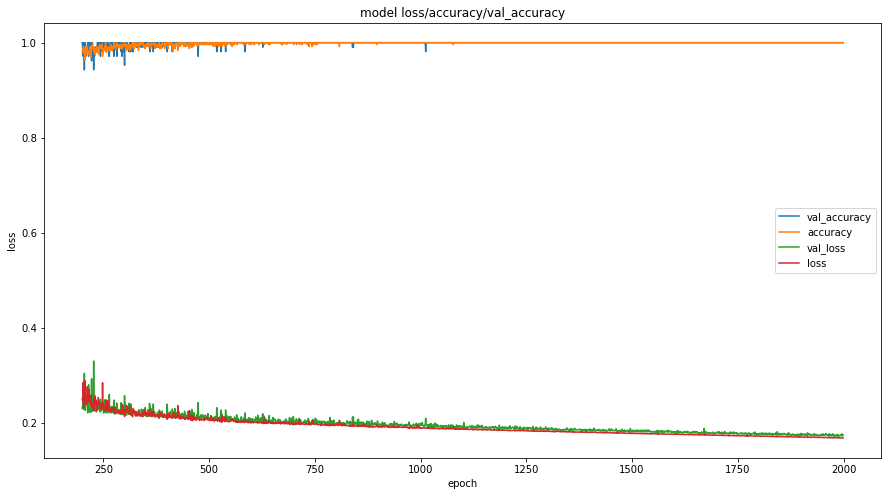

In [27]:
plot_nn_result(200, history)

In [26]:
print('test loss, test acc:', model_wine.evaluate(x_test, y_test))

150/150 [==============================] - 0s 166us/step
test loss, test acc: [0.21922053237756092, 0.9733333587646484]


In [75]:
#model_wine.save('best_fuel_model')